In [1]:
# import packages and existing code/functions

import glob
import os
from lsst import afw
#print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std

import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift

import math
from scipy.ndimage import gaussian_filter

from mytool import plotonesensor_ITL, plotonesensor_ITL_smooth, create_combined_ITL
import numpy as np
import numpy

import matplotlib.pyplot as plt

%matplotlib inline

20.0.0-4-gde602ef96+1


In [2]:
# set up file paths for ts8 to make combined flat displaying full sensor

# looking at Raft 13, CCD 21, run 10982 (must be a good run) .... same as in testing_making_flat_from_lamda notebook

superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-013/RTM-013-10982-S21_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-013/RTM-013-10982-S21_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/*_lambda_flat_*")
qeflatpath.sort()

In [3]:
# array of wavelengths

wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])
print(wls)

[ 319.994  324.969  349.982  374.975  400.019  424.965  450.035  475.003
  500.018  525.002  550.029  575.023  599.982  619.997  624.979  650.012
  675.004  700.03   725.012  750.022  774.987  799.976  824.988  850.022
  869.967  875.002  899.999  919.999  925.012  949.965  975.002  999.976
 1025.028 1050.014 1075.002 1099.99 ]


[1.15429078e-017 4.05581626e-014 1.30240668e-002 1.47383243e-001
 5.60866589e-011 1.02343173e-030 3.63772687e-061 6.36388808e-102
 3.73616607e-153 7.95497194e-215 5.70088782e-287 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]


Text(0.5, 1.0, 'Response Curve/SED for CCOB$_{UV}$')

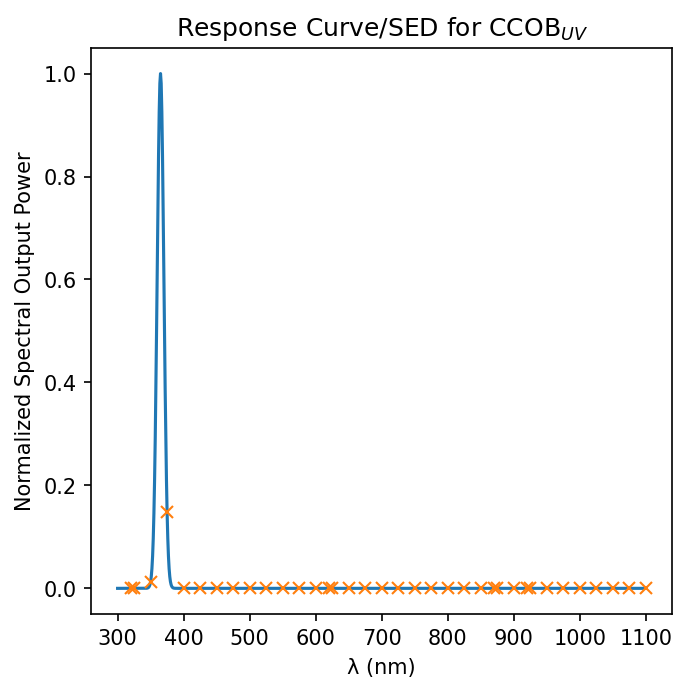

In [4]:
# response function at UV band using LSST filters, not SDSS
# x and y functions are a numpy.array , they replace the sdssfilter[2].data["wavelength"] and sdssfilter[2].data["respt"] respectively


fig, axs = pylab.subplots(figsize=(5,5),dpi=150)
# [('wavelength', '>f4'), ('respt', '>f4'), ('resbig', '>f4'), ('resnoa', '>f4'), ('xatm', '>f4')]

wavelengths_list = [365, 466.6, 622.6, 759.9, 845.7, 950.5]
width_of_wavelength_list = [12, 25, 18, 28, 32, 60]
width_of_wavelength_list_converted = []
for num in width_of_wavelength_list:
    z = num / 2.355
    width_of_wavelength_list_converted.append(z)
# now wavelength widths converted from FWHM to sigma

# want to use the uv band, so the first element in each list
mu = wavelengths_list[0]
sigma = width_of_wavelength_list_converted[0]

a = 1    # to normalize
x = numpy.arange(300,1100,1)  
         # gaussians #
y = a*numpy.exp(-(x-mu)**2/(2*sigma**2))
# plots the gaussians
pylab.plot(x, y)

# corrects for the difference in resolution for each wavelength in wls, it will interpolate numbers at wls*10 for this case.
# interpolation is a method of curve fitting using linear polynomials to construct NEW data points within the range of a discrete set of KNOWN data points
weights = numpy.interp(wls, x, y)    # THIS FUNCTION IS CALLED LATER ON, RESPONSIBLE FOR CREATING COMBINED FOR UV BAND #
print(weights)
# plots 'x's
pylab.plot(wls, weights,"x")


# labeling plot
pylab.xlabel("λ (nm)")
pylab.ylabel("Normalized Spectral Output Power")
pylab.title("Response Curve/SED for CCOB$_{UV}$")

In [5]:
def create_ccob(img_list):
    num_ch = 16
    uv_arr = [None] * num_ch
    normedimg_arr = [None] * num_ch
    MEDIAN = None

    fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_uv_-211.815_-0.395.fits"     
    ccob_uv = get_ccd_from_id(None, fname, [])

    # reading in files in CCOB testing at uv LED for each of 16 channels 
    for ch in range(num_ch):    
        uv = get_data_as_read(ccob_uv,ch + 1,["imaging"])["imaging"]    # QE data array for CCOBuv flat field image
        MEDIAN = numpy.median(uv)                                        # median (not mean, avoiding outliers) of QE data array for CCOBuv, will normalize COMBINED with this
        normedimg = img_list[ch] / numpy.median(img_list[ch]) * MEDIAN    # normalizing COMBINED against the CCOB amp-by-amp to the level of the CCOB median 
        normedimg_arr[ch] = normedimg                                     # adding data at this amp to data array
        uv_arr[ch] = uv
    return normedimg_arr, uv_arr

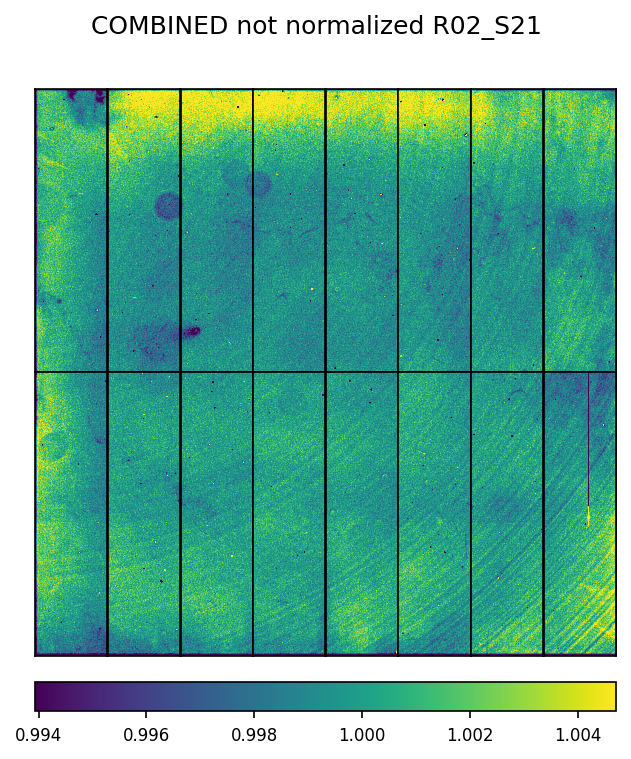

([array([[39807.36 , 38365.863, 36730.6  , ..., 35478.92 , 35129.254,
          35885.69 ],
         [47232.68 , 46261.906, 45177.84 , ..., 43206.758, 43557.895,
          43392.617],
         [49982.62 , 49585.77 , 49125.18 , ..., 47694.074, 45918.484,
          47302.953],
         ...,
         [58411.855, 58897.37 , 59030.883, ..., 57427.1  , 56703.055,
          55988.84 ],
         [58319.613, 60244.28 , 58525.246, ..., 57438.28 , 56545.105,
          56468.492],
         [58995.992, 59233.664, 58368.008, ..., 57532.28 , 56715.902,
          55494.55 ]], dtype=float32),
  array([[39612.477, 37805.29 , 36967.297, ..., 38615.324, 38912.48 ,
          40011.562],
         [46835.7  , 46898.82 , 45824.605, ..., 46890.418, 46525.14 ,
          47327.227],
         [50195.355, 50091.273, 48859.08 , ..., 50078.48 , 49641.004,
          50389.89 ],
         ...,
         [58767.125, 58871.848, 59423.605, ..., 59043.44 , 58148.996,
          58434.145],
         [58893.164, 59149.273, 591

In [9]:
title = "COMBINED not normalized R02_S21"
img_list = create_combined_ITL(superdarkpath, superbiaspath, qeflatpath, weights, title)    # create_combined returns img_list at end of function
create_ccob(img_list)

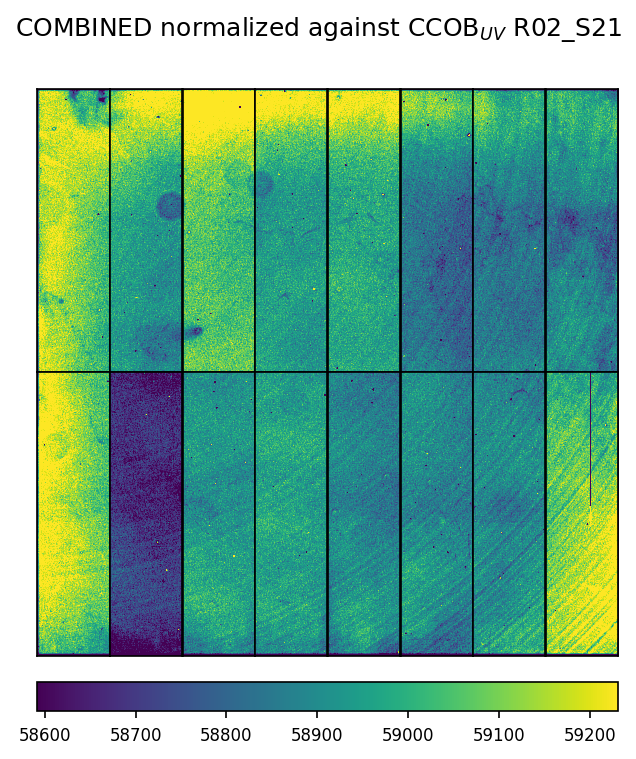

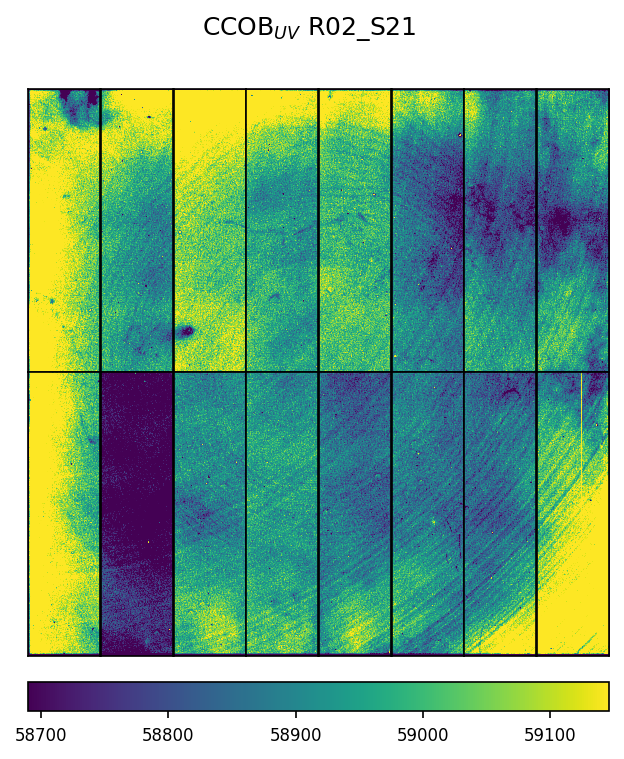

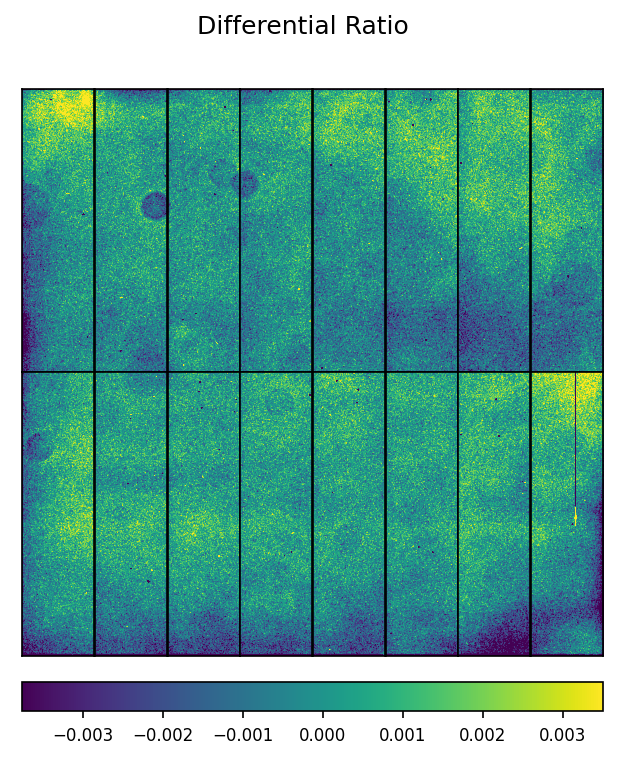

In [10]:
# default color map
num_ch = 16
normedimg_arr, uv_arr = create_ccob(img_list)

# plot normalized, COMBINED flat
plotonesensor_ITL(normedimg_arr, 'COMBINED normalized against CCOB$_{UV}$ R02_S21')

# plot CCOBred flat
plotonesensor_ITL(uv_arr, 'CCOB$_{UV}$ R02_S21')

# plot Ratio flat, the one of interest!
diff_arr = [None] * num_ch
for i in range(num_ch):
    diff_arr[i] = (normedimg_arr[i] - uv_arr[i]) / uv_arr[i]
plotonesensor_ITL(diff_arr, 'Differential Ratio')

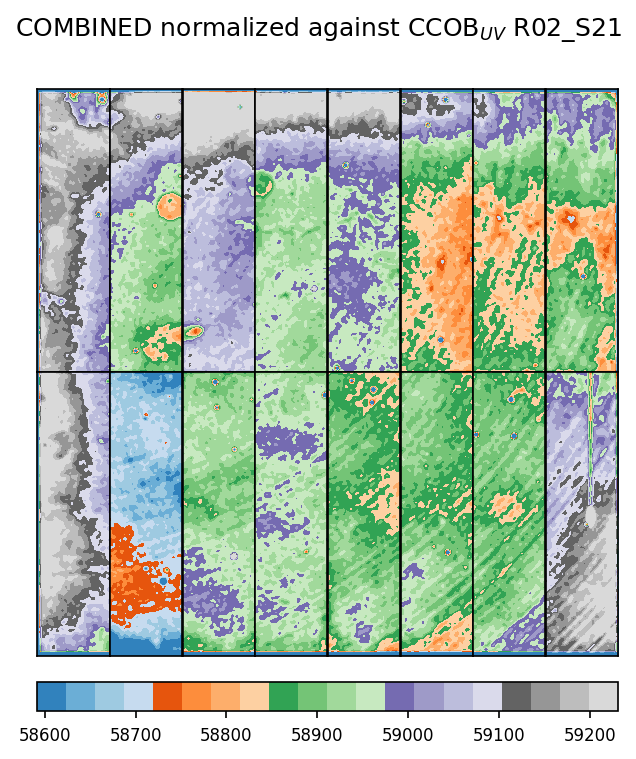

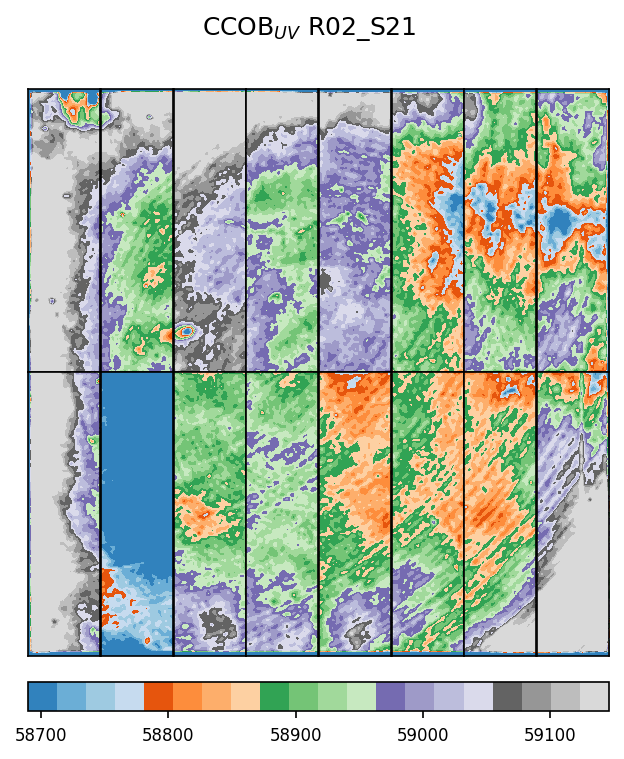

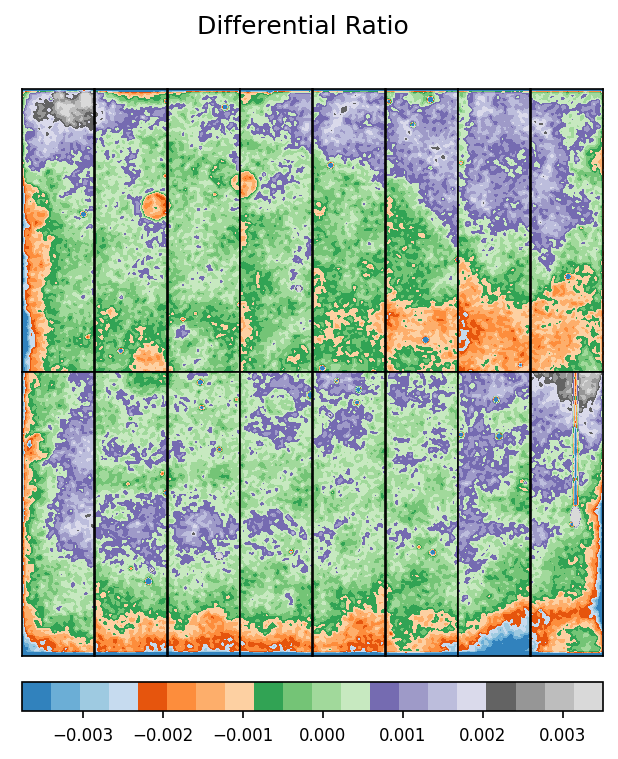

In [11]:
# smoothed plots

# plot normalized, COMBINED flat
plotonesensor_ITL_smooth(normedimg_arr, 'COMBINED normalized against CCOB$_{UV}$ R02_S21')

# plot CCOBred flat
plotonesensor_ITL_smooth(uv_arr, 'CCOB$_{UV}$ R02_S21')

# plot Ratio flat, the one of interest!
diff_arr = [None] * num_ch
for i in range(num_ch):
    diff_arr[i] = (normedimg_arr[i] - uv_arr[i]) / uv_arr[i]
    
plotonesensor_ITL_smooth(diff_arr, 'Differential Ratio')